## Importing dependencies

In [5]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator

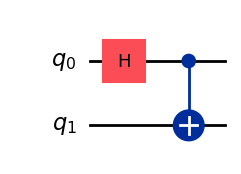

In [6]:
# creating a new circuit with 2 qubits
qc = QuantumCircuit(2)

# applying hadamard gate to qubit 0
qc.h(0)

# controlled-x gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)

# return a drawing of the circuit using mpl
qc.draw("mpl")

In [7]:
# setting up six different observables
observables_labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"]
observables = [SparsePauliOp(label) for label in observables_labels]

In [8]:
# fetching the api key from env
from dotenv import load_dotenv
load_dotenv(".env")
from os import getenv

TOKEN = getenv("TOKEN")
if not TOKEN:
    print("error: TOKEN not set in env")

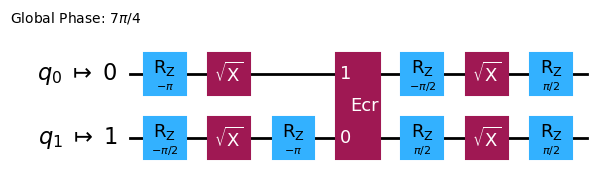

In [9]:
from qiskit_ibm_runtime import QiskitRuntimeService

# creating a backend service
service = QiskitRuntimeService(channel="ibm_quantum", token=TOKEN)

backend = service.least_busy(simulator=False, operational=True)

# convert to an ISA circuit and layout-mapped observables
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

isa_circuit.draw("mpl", idle_wires=False)


In [14]:
# constructing the estimator instance
estimator = Estimator(mode=backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000

mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

# one pub with one circuit to run against five different observables
job = estimator.run([(isa_circuit, mapped_observables)])

# job id to retrieve your job data later
print(f">>> Job ID: {job.job_id()}")

>>> Job ID: cwybec9ehebg008jqrsg


In [15]:
# retrieving the result of the job
job_result = job.result()

pub_result = job_result[0]


In [24]:
# alternate: running using a simulator
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2
f_backend = FakeAlmadenV2()
f_estimator = Estimator(f_backend)

# convert to an ISA circuit and layout-mapped observables
f_pm = generate_preset_pass_manager(backend=f_backend, optimization_level=1)
f_isa_circuit = f_pm.run(qc)
mapped_observables = [
    observable.apply_layout(f_isa_circuit.layout) for observable in observables
]

f_job = f_estimator.run([(f_isa_circuit, mapped_observables)])
print(f">>> Fake Job ID: {f_job.job_id()}")
f_job_result = f_job.result()
f_pub_result = f_job_result[0]

>>> Fake Job ID: baf97ff0-80fb-4cc7-ace6-1e318c7090cc


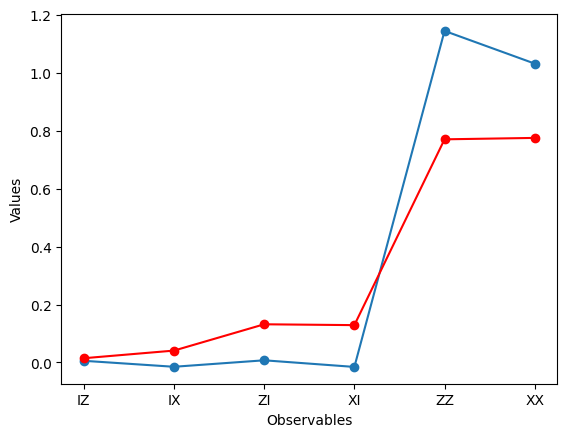

In [25]:
# plotting the result
from matplotlib import pyplot as plt

values = pub_result.data.evs
f_values = f_pub_result.data.evs
errors = pub_result.data.stds

plt.plot(observables_labels, values, "-o")
plt.plot(observables_labels, f_values, "-o", color="red")


plt.xlabel("Observables")
plt.ylabel("Values")
plt.show()